In [149]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#import functions from my .py files
from acquire import get_zillow_data
from prep import remove_outliers,remove_outlier, split_continuous, clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale
from explore import plot_variable_pairs, plot_pairplot, plot_categorical_and_continuous_vars, correlation_exploration
from feature_engineering import select_kbest

In [2]:
df = get_zillow_data()

In [3]:
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,NaN,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,NaN,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,NaN,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,NaN,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,NaN,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,NaN,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,NaN,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,NaN,NaN,6.037108e+13,72843,0.024946,2017-08-31


In [4]:
def clean_zillow(df):
    '''
    this function takes in an unclean zillow df and does the following:
    1.) keeps only columns we need for the project
    2.) drops nulls
    3.) renames columns
    '''
    #select features for df
    features = ['parcelid', 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'yearbuilt','fips']
    df = df[features]
    df['yearbuilt'].fillna(2017, inplace = True)
    df['age'] = 2017-df['yearbuilt']
    df = df.drop_duplicates(subset=['parcelid'])
    
    #rename columns for easier use
    df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'baths',
                            'bedroomcnt': 'beds',
                            'taxvaluedollarcnt':'tax_value'
        
    })
    
    #set index
    df = df.set_index('parcel_id')
    #drop nulls
    df = df.dropna(subset=['sqft','tax_value'])
    #drop year_built
    df = df.drop(columns=['yearbuilt'])
    
    return df

In [5]:
df = clean_zillow(df)
df.describe()

,sqft,baths,beds,tax_value,fips,age
count,38475.000000,38475.000000,38475.000000,3.847500e+04,38475.000000,38475.000000
mean,1762.382248,2.280078,3.018739,4.950518e+05,6049.885302,47.442677
std,926.862162,0.943460,1.015443,6.279530e+05,21.410321,23.077580
min,240.000000,0.000000,0.000000,1.000000e+03,6037.000000,0.000000
25%,1174.000000,2.000000,2.000000,2.091760e+05,6037.000000,30.000000
50%,1525.000000,2.000000,3.000000,3.637970e+05,6037.000000,46.000000
75%,2082.000000,3.000000,4.000000,5.770830e+05,6059.000000,63.000000
max,17245.000000,11.000000,12.000000,2.385837e+07,6111.000000,139.000000


In [6]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,6037.0,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,6037.0,48.0


In [7]:
def remove_outlier(df):
    '''
    Another outlier removal function. This one will remove values that are 3 standard deviations above or below the mean
    '''
    new_df = df[(np.abs(stats.zscore(df['sqft'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['baths'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['beds'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['tax_value'])) < 3)]
    return new_df

In [8]:
df = remove_outlier(df)

In [9]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,6037.0,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,6037.0,48.0


In [10]:
df.describe()

,sqft,baths,beds,tax_value,fips,age
count,37927.000000,37927.000000,37927.000000,3.792700e+04,37927.000000,37927.000000
mean,1719.082079,2.243929,2.999815,4.436511e+05,6049.965275,47.567327
std,817.108495,0.879170,0.998060,3.567333e+05,21.484878,22.962371
min,240.000000,0.000000,0.000000,1.000000e+03,6037.000000,0.000000
25%,1169.000000,2.000000,2.000000,2.069000e+05,6037.000000,30.000000
50%,1512.000000,2.000000,3.000000,3.589300e+05,6037.000000,46.000000
75%,2050.000000,3.000000,4.000000,5.634630e+05,6059.000000,63.000000
max,11020.000000,10.000000,11.000000,2.377148e+06,6111.000000,139.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37927 entries, 14634203 to 10713993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       37927 non-null  float64
 1   baths      37927 non-null  float64
 2   beds       37927 non-null  float64
 3   tax_value  37927 non-null  float64
 4   fips       37927 non-null  float64
 5   age        37927 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB


In [12]:
df.isna().sum()

sqft         0
baths        0
beds         0
tax_value    0
fips         0
age          0
dtype: int64

In [13]:
target = 'tax_value'

In [14]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)

In [15]:
train.shape, validate.shape, test.shape

((21238, 6), (9103, 6), (7586, 6))

In [16]:
obj_cols = get_object_cols(df)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [17]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

In [18]:
X_train_scaled

,sqft,baths,beds,fips,age
13850720,0.150306,0.2500,0.363636,0.297297,0.417266
11788265,0.037855,0.1250,0.090909,0.000000,0.676259
12738578,0.143069,0.2500,0.272727,0.000000,0.402878
12264415,0.034329,0.1250,0.181818,0.000000,0.489209
12682786,0.138987,0.2500,0.363636,0.000000,0.438849
...,...,...,...,...,...
14608400,0.098905,0.3125,0.181818,0.297297,0.093525
12896021,0.059009,0.2500,0.181818,0.000000,0.266187
14463176,0.173873,0.3750,0.363636,0.297297,0.129496
14394382,0.136853,0.3125,0.272727,0.297297,0.194245


In [23]:
select_kbest(X_train_scaled, y_train,4)

['sqft', 'baths', 'beds', 'age']

In [22]:
#tells us which features we should keep
import statsmodels.api as sm
cols = list(X_train_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['sqft', 'baths', 'beds', 'age']


In [24]:
#using RFE
number_of_features_list=np.arange(1,7)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 4
Score with 4 features: 0.376712


In [25]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 4)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'age'], dtype='object')


In [37]:
selected_features = ['sqft', 'baths', 'beds', 'age']

In [26]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('BASELINE')
print('--------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('--------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

BASELINE
--------------------
RMSE using Mean
Train/In-Sample:  357185.61 
Validate/Out-of-Sample:  359454.06
--------------------
RMSE using Median
Train/In-Sample:  367038.13 
Validate/Out-of-Sample:  369101.89


In [27]:
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {r2_baseline}')

The r^2 score for baseline is -3.072081049992903e-06


In [39]:
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.6834686621


In [40]:
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
r2_score_lm

0.3946386945306427

In [42]:
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Lasso+Lars
Training/In-Sample:  280731.6019596922 
Validation/Out-of-Sample:  279675.51693743526


In [43]:
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
r2_score_lars

0.3946264281839741

In [121]:
#create model object
glm = TweedieRegressor(power =0, alpha=0.00)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using TweedieRegressor
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.68346835295


In [122]:
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
r2_score_glm

0.39463869453198086

In [97]:
#making polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

In [100]:
#okay let's do linear regression again
lm3 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm3.fit(X_train_degree2, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm3)**(1/2)

#predict validate
y_validate['tax_value_pred_lm3'] = lm3.predict(X_validate_degree2)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  276310.6526820274 
Validation/Out-of-Sample:  274076.30740976887


In [101]:
r2_score_lm3 = round(r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm3),2)
r2_score_lm3

0.42

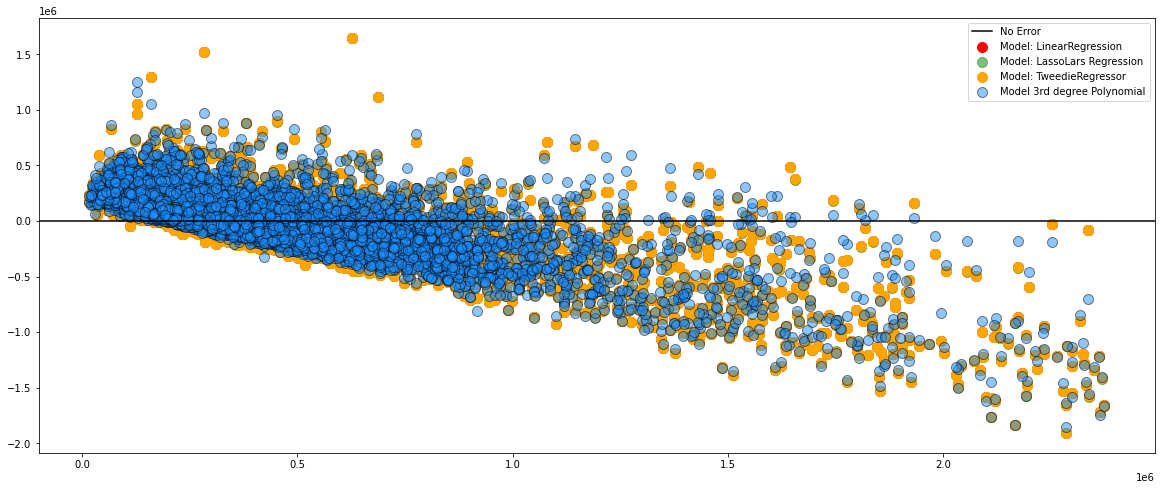

In [147]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

<AxesSubplot:xlabel='tax_value', ylabel='tax_value_pred_lm2'>

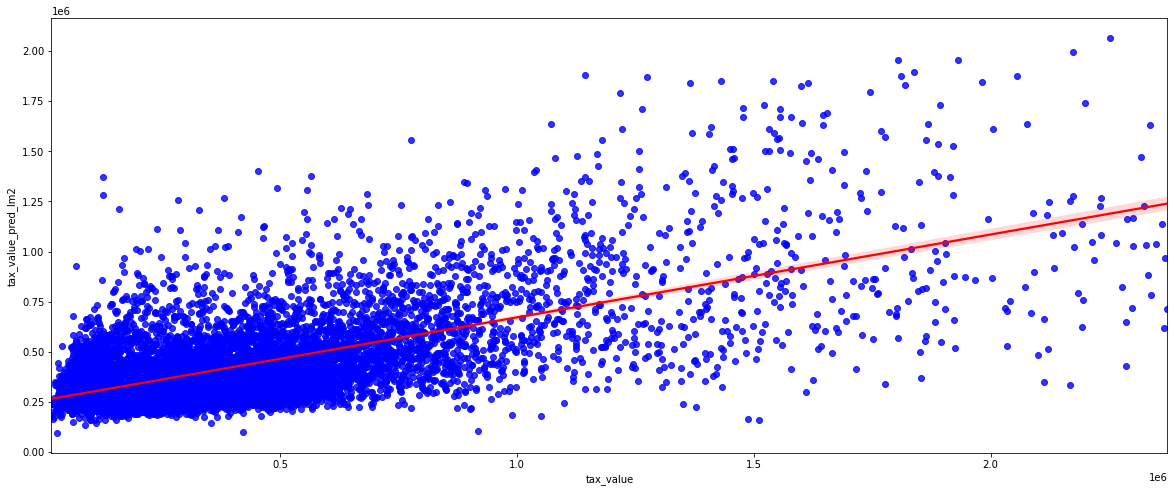

In [148]:
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm2, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})